In [400]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plot_fairness_metrics import *

In [401]:
from sklearn.preprocessing import QuantileTransformer

def remove_disparate_impact_global(df, features, protected_attr, repair_level=0.5):
    df = df.copy()
    
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan

        # Global reference distribution
        qt_global = QuantileTransformer(output_distribution='normal')
        global_transformed = qt_global.fit_transform(df[[feature]]).flatten()

        df[f"{feature}_quantile"] = global_transformed  # for interpolation

        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            original = df.loc[group_mask, feature]
            transformed = df.loc[group_mask, f"{feature}_quantile"]
            repaired = (1 - repair_level) * original + repair_level * transformed
            df.loc[group_mask, repaired_col] = repaired

        df.drop(columns=[f"{feature}_quantile"], inplace=True)

    return df


In [402]:
from sklearn.preprocessing import QuantileTransformer
import pandas as pd
import numpy as np

def remove_disparate_impact(df, features, protected_attr, repair_level=0.5):

    df = df.copy()
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan
        
        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            group_values = df.loc[group_mask, feature].values.reshape(-1, 1)
            
            qt = QuantileTransformer(output_distribution='normal')
            transformed = qt.fit_transform(group_values).flatten()
            
            original = df.loc[group_mask, feature]
            repaired = (1 - repair_level) * original + repair_level * transformed
            
            df.loc[group_mask, repaired_col] = repaired

    return df


In [403]:
df = pd.read_csv('complete_df_with_predictions.csv')
df_copied = df.copy()
predicted_cols = ['pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r']
df.drop(columns=predicted_cols, inplace=True)

In [404]:
race_enc = LabelEncoder()
df['race1_encoded'] = race_enc.fit_transform(df['race1'])

In [405]:
race_mapping = dict(zip(race_enc.classes_, race_enc.transform(race_enc.classes_)))
print(race_mapping)

{'asian': 0, 'black': 1, 'hisp': 2, 'other': 3, 'white': 4}


In [406]:
nokeep = ['bar', 'race2', 'race1']
keep = list(set(df.columns) - set(nokeep))
df = df[keep]

In [407]:
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race1_encoded']

target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [408]:
df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

In [409]:
new_features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'race1_encoded_repaired', 'tier_repaired', 'fam_inc_repaired']

In [410]:
features_to_repair = ['race1_encoded', 'tier', 'fam_inc']
df_train_rw = remove_disparate_impact(df_train, features=features_to_repair, protected_attr='race1_encoded', repair_level=1.0)
X_train_rw = df_train_rw[new_features]
y_train_rw = df_train_rw[target]

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (814). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (711). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (814). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local

In [411]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

param_grid = {
    'C': [0.01, 0.1, 1, 10], #normalization
    'class_weight': [{0: w0, 1: 1} for w0 in [5, 10, 20, 50, 100]] # we try penalizing more only class 0 mistakes
}

lr = LogisticRegression(max_iter=1000, solver='liblinear') 


fbeta_scorer = make_scorer(fbeta_score, beta=1.41, pos_label=0)
                               
grid_search = GridSearchCV(lr, param_grid, scoring=fbeta_scorer, cv=5, n_jobs=-1)

grid_search.fit(X_train_rw, y_train_rw)

lr_best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best Fbeta-score for class 0:", grid_search.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 5, 1: 1}}
Best Fbeta-score for class 0: 0.39349000560936087


In [412]:
# from sklearn.metrics import confusion_matrix, classification_report


# y_test_pred = lr_best_model.predict(X_test)

# print(confusion_matrix(y_test, y_test_pred))
# print(classification_report(y_test, y_test_pred))

### on whole dataset

In [413]:
features_to_repair = ['race1_encoded', 'tier', 'fam_inc']  # , 'tier', 'fam_inc'
df_rw = remove_disparate_impact_global(df, features=features_to_repair, protected_attr='race1_encoded', repair_level=1.0)

In [414]:
df_rw

,race1_black,ugpa,race1_encoded,bar1_yr,decile1,academic_career,race1_hisp,decile3,zfygpa,race1_other,...,fam_inc,lsat,pass_bar,tier,Unnamed: 0,zgpa,parttime,race1_encoded_repaired,tier_repaired,fam_inc_repaired
0,False,3.5,4,7.0,10.0,1.341087,False,10.0,1.33,False,...,5.0,44.0,1,4.0,0,1.88,0.0,5.199338,0.249721,5.199338
1,False,3.5,4,7.0,5.0,-0.385252,False,4.0,-0.11,False,...,4.0,29.0,1,2.0,1,-0.57,0.0,5.199338,-1.501861,0.512061
2,False,3.5,4,7.0,3.0,-0.355093,False,2.0,-0.64,False,...,1.0,36.0,1,3.0,2,-1.12,0.0,5.199338,-0.570161,-5.199338
3,False,3.5,4,7.0,7.0,0.217453,False,4.0,0.34,False,...,4.0,39.0,1,3.0,3,-0.49,0.0,5.199338,-0.570161,0.512061
4,False,3.5,4,7.0,9.0,1.144843,False,8.0,1.02,False,...,4.0,48.0,1,5.0,4,0.76,0.0,5.199338,0.908975,0.512061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,True,1.8,1,2.0,3.0,-1.922560,False,1.0,-0.58,False,...,2.0,26.5,0,1.0,22402,-1.49,0.0,-1.471555,-5.199338,-1.490335
22068,True,1.8,1,7.0,3.0,-2.216261,False,1.0,-0.64,False,...,3.0,19.7,0,1.0,22403,-1.36,0.0,-1.471555,-5.199338,-0.539431
22069,True,1.8,1,7.0,7.0,-0.613914,False,8.0,0.41,False,...,3.0,36.0,1,3.0,22404,0.80,1.0,-1.471555,-0.570161,-0.539431
22070,False,1.5,4,7.0,10.0,0.134185,False,10.0,1.88,False,...,3.0,44.0,1,3.0,22405,1.42,1.0,5.199338,-0.570161,-0.539431


In [ ]:
pass_bar_lr_rw = lr_best_model.predict(df_rw[new_features])
df_rw['pass_bar_lr_rw'] = pass_bar_lr_rw

In [416]:
df_rw

,race1_black,ugpa,race1_encoded,bar1_yr,decile1,academic_career,race1_hisp,decile3,zfygpa,race1_other,...,lsat,pass_bar,tier,Unnamed: 0,zgpa,parttime,race1_encoded_repaired,tier_repaired,fam_inc_repaired,pass_bar_lr_rw
0,False,3.5,4,7.0,10.0,1.341087,False,10.0,1.33,False,...,44.0,1,4.0,0,1.88,0.0,5.199338,0.249721,5.199338,1
1,False,3.5,4,7.0,5.0,-0.385252,False,4.0,-0.11,False,...,29.0,1,2.0,1,-0.57,0.0,5.199338,-1.501861,0.512061,1
2,False,3.5,4,7.0,3.0,-0.355093,False,2.0,-0.64,False,...,36.0,1,3.0,2,-1.12,0.0,5.199338,-0.570161,-5.199338,1
3,False,3.5,4,7.0,7.0,0.217453,False,4.0,0.34,False,...,39.0,1,3.0,3,-0.49,0.0,5.199338,-0.570161,0.512061,1
4,False,3.5,4,7.0,9.0,1.144843,False,8.0,1.02,False,...,48.0,1,5.0,4,0.76,0.0,5.199338,0.908975,0.512061,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,True,1.8,1,2.0,3.0,-1.922560,False,1.0,-0.58,False,...,26.5,0,1.0,22402,-1.49,0.0,-1.471555,-5.199338,-1.490335,0
22068,True,1.8,1,7.0,3.0,-2.216261,False,1.0,-0.64,False,...,19.7,0,1.0,22403,-1.36,0.0,-1.471555,-5.199338,-0.539431,0
22069,True,1.8,1,7.0,7.0,-0.613914,False,8.0,0.41,False,...,36.0,1,3.0,22404,0.80,1.0,-1.471555,-0.570161,-0.539431,1
22070,False,1.5,4,7.0,10.0,0.134185,False,10.0,1.88,False,...,44.0,1,3.0,22405,1.42,1.0,5.199338,-0.570161,-0.539431,1


In [417]:
print(df_rw['race1_encoded_repaired'].describe())
print(df_rw['race1_encoded_repaired'].nunique())
print(df_rw['race1_encoded_repaired'].value_counts())

count    22072.000000
mean         3.981093
std          2.838821
min         -5.199338
25%          5.199338
50%          5.199338
75%          5.199338
max          5.199338
Name: race1_encoded_repaired, dtype: float64
5
race1_encoded_repaired
 5.199338    18462
-1.471555     1308
-1.157061     1010
-5.199338      888
-1.012474      404
Name: count, dtype: int64


In [418]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd

def compute_disparate_impact_by_race(df, label_col='pass_bar', race_col='race1_encoded', white_label=4):
    results = []

    # Filter all unique race codes except White (reference group)
    race_codes = sorted(df[race_col].unique())
    other_races = [r for r in race_codes if r != white_label]

    for group in other_races:
        # Create dataset with only White and one comparison group
        df_pair = df[df[race_col].isin([white_label, group])].copy()
        df_pair[race_col + '_bin'] = df_pair[race_col].apply(lambda x: 1 if x == white_label else 0)

        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df_pair,
            label_names=[label_col],
            protected_attribute_names=[race_col + '_bin']
        )

        metric = BinaryLabelDatasetMetric(
            dataset,
            privileged_groups=[{race_col + '_bin': 1}],  # White
            unprivileged_groups=[{race_col + '_bin': 0}]  # Current group
        )

        di = metric.disparate_impact()

        results.append({
            'Group': f'{group} vs White',
            'Disparate Impact': di
        })

    return pd.DataFrame(results)

di_results = compute_disparate_impact_by_race(df_rw, label_col='pass_bar_lr_rw', race_col='race1_encoded', white_label=4)
print(di_results)

        Group  Disparate Impact
0  0 vs White          0.882883
1  1 vs White          0.880734
2  2 vs White          0.973267
3  3 vs White          0.975248


c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

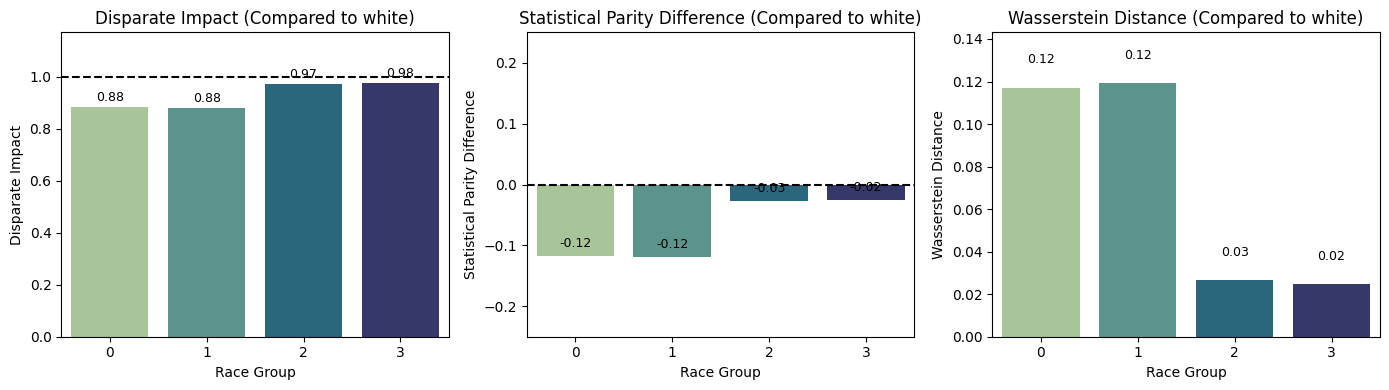

In [419]:
race_groups = [0, 1, 2, 3]
results = get_DI_SPD_WD(race_groups, df_rw, 'race1_encoded', 4, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Race Group', 'white')

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

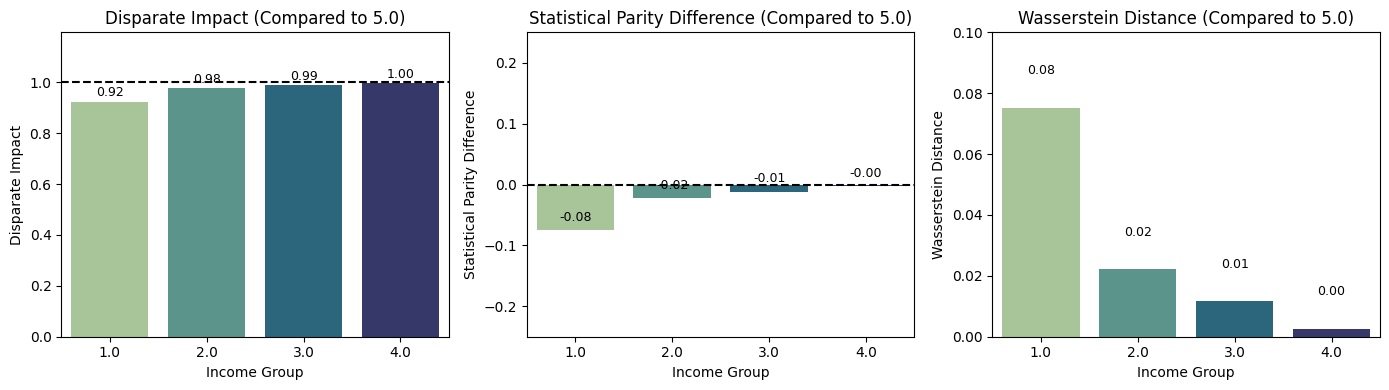

In [420]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df_rw, 'fam_inc', 5.0, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Income Group', 5.0)

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

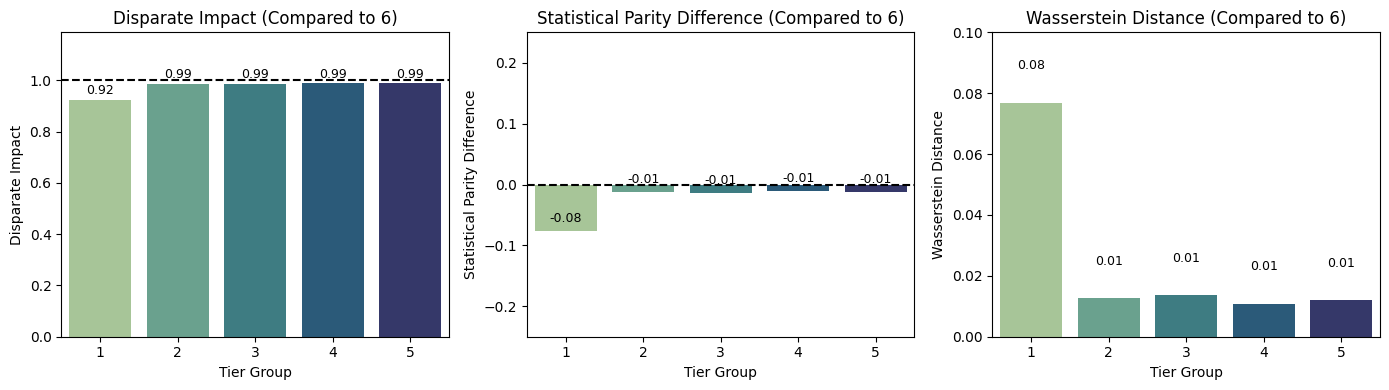

In [421]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df_rw, 'tier', 6, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Tier Group', 6)

## Method explanation
The method used is not textbook, but was necessary in order to reduce the bias in a way which made sense, as it was specifically hard to tackle in the preprocessing case. The textbook approaches didn't seem to work at all. The Disparate Impact Remover library from AIF360 is at the moment not working because of technical problems on their side, so I decided to implement a similar approach by hand. 

Disparate Impact is a metric which has a threshold of 1, and we generally enforce the 80% rule, meaning that if the values drop below 80% the feature is considered unacceptably biased. DIR is a preprocessing fairness technique which transforms the feature distributions so that protected group membership can no longer be easily inferred. So it alters the ability of the features to be proxies for group identities. More easily, we are hiding where a specific individual belongs to. Another added challenge in this instance was tackling three different features at the same time. It was also proven that using the disparate impact remover on one feature at a time produced worse overall results (80% rule was not respected).

To implement this technique, I used a combination of two functions: 
1) <remove_disparate_impact()> which performs per group normalization, meaning that it assumes that each group has its own individual distribution and it tries to make each group internally fair according to the same normal distribution. 

2) <remove_disparate_impact_global()> which assumes that the main issue is inter-group disparity, and it basically forces all features to have the same distribution.

In this case, we train the model on df_train transformed according to the first function, and then we create the new prediction label by performing a prediction on the whole dataset transformed with the second function. 

**why it works**
The Logistic Regression model is linear, it generalizes better if the input distribution matches what it was trained on. And the second function flattens the group-wise differences in df, effectively mimicking the per-group normalization seen in training.

In the case of logistic regression, we are dealing with a linear model, meaning that it works specifically well with this type of bias mitigation, while it might not be the case for XGBoost and Random Forest. 

